In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
import numpy as np
import time
import sys
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)



## In this project I present a model which takes in two different questions and classifies them based on if they are duplicate or not. The data is from Quora dataset, and contains supervised pairs of questions and labels based on whether the questions are duplicate or not.
I present two plots, of feature selection and one of model selection.

Plot 1,2 shows that transformed duplicate questions have high cosine similarity and eucldean distances as compared to non duplicate questions

Plot 3 shows model selection ln Logistic regression on Bag of words model on the dataset without any additional features. A baseline acuracy of 80 % is achieved. Application of XGBoost shows 82.5% accuracy (2.5 % acuracy improvement) as compared to Logistic regression. 

A word2vec baseline model is at a below link on my github page ... requires 32 GB Memory machine to run ..
score accuracy is 76% on the validation set with 80/20 split
https://github.com/aspk/Quora_question_pairs_NLP_Kaggle/blob/master/quora_word_to_vec_addition/quora_question_pairs_xgboost_sklearn.ipynb

Addtion of features with and the two models was used to form an ensemble model with 83% + accuracy 



# Dataset

In [3]:
train = pd.read_csv('train.csv')
train = train.dropna(how="any").reset_index(drop=True)

train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Plot 1

A plot of cosine distances of histograms is shown for duplicate and non diuplicate questions. I observed a smaller median of 0.36 for duplicates as compared to 0.59 for non duplicates for the questions. Other distance metrics like eucledian distances are considered as well.These features could be use in logistic regession along with TfIDF ZVectorizer

In [4]:
def getBOW(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    # bag of letter sequences (chars)
    """
    BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)
    """
    
    BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)

    BOW.fit(pd.concat((train['question1'],train['question2'])).unique())
    print('Voabulary size is {}'.format(len(BOW.vocabulary_)))
    return BOW
BOW = getBOW(min_df=100,ngrams = 1,analyzer = 'word')

Voabulary size is 4412


In [10]:
trainq1_trans = BOW.transform(train['question1'][train['is_duplicate']==1].values)
trainq2_trans = BOW.transform(train['question2'][train['is_duplicate']==1].values)
trainq1_trans_non = BOW.transform(train['question1'][train['is_duplicate']==0].values)
trainq2_trans_non = BOW.transform(train['question2'][train['is_duplicate']==0].values)


In [12]:
from scipy import spatial
trainq1_trans = trainq1_trans.toarray()
trainq2_trans = trainq2_trans.toarray()

trainq1_trans_non = trainq1_trans_non.toarray()
trainq2_trans_non = trainq2_trans_non.toarray()

sim_cos_dist = np.zeros(trainq1_trans.shape[0])
sim_cos_dist_non = np.zeros(trainq1_trans_non.shape[0])

for i in range(trainq1_trans.shape[0]):
    sim_cos_dist[i] = spatial.distance.cosine(trainq1_trans[i],trainq2_trans[i])
    
for i in range(trainq1_trans_non.shape[0]):
    sim_cos_dist_non[i] = spatial.distance.cosine(trainq1_trans_non[i],trainq2_trans_non[i])

/Users/akhileshsk/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Text(0,0.5,'Count')

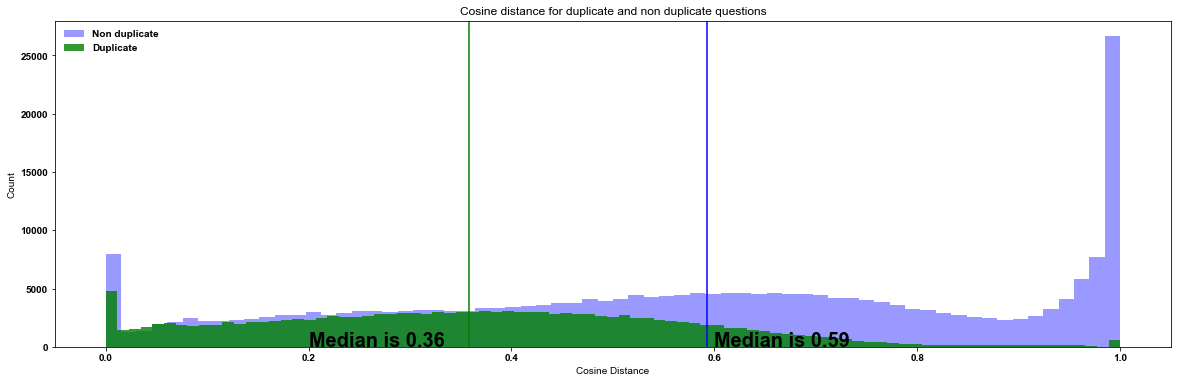

In [13]:
plt.figure(figsize=(20,6))

sim_cos_dist = sim_cos_dist[~np.isnan(sim_cos_dist)]
sim_cos_dist_non = sim_cos_dist_non[~np.isnan(sim_cos_dist_non)]

n, bins, patches = plt.hist(sim_cos_dist_non, bins = 'auto', density=0, facecolor='b', alpha=0.4,label = 'Non duplicate')
n, bins, patches = plt.hist(sim_cos_dist, bins = 'auto', density=0, facecolor='g', alpha=0.8,label = 'Duplicate')
plt.legend(frameon = False)
plt.axvline(np.median(sim_cos_dist_non),color = 'b')
plt.axvline(np.median(sim_cos_dist),color = 'g')
ax = plt.gca()
ax.text(0.2,1, 'Median is {}'.format(np.round(np.median(sim_cos_dist),2)),size=20)
ax.text(0.6,1, 'Median is {}'.format(np.round(np.median(sim_cos_dist_non),2)),size=20)


plt.title('Cosine distance for duplicate and non duplicate questions')
plt.xlabel('Cosine Distance')
plt.ylabel('Count')



# Plot 2

Text(0,0.5,'Count')

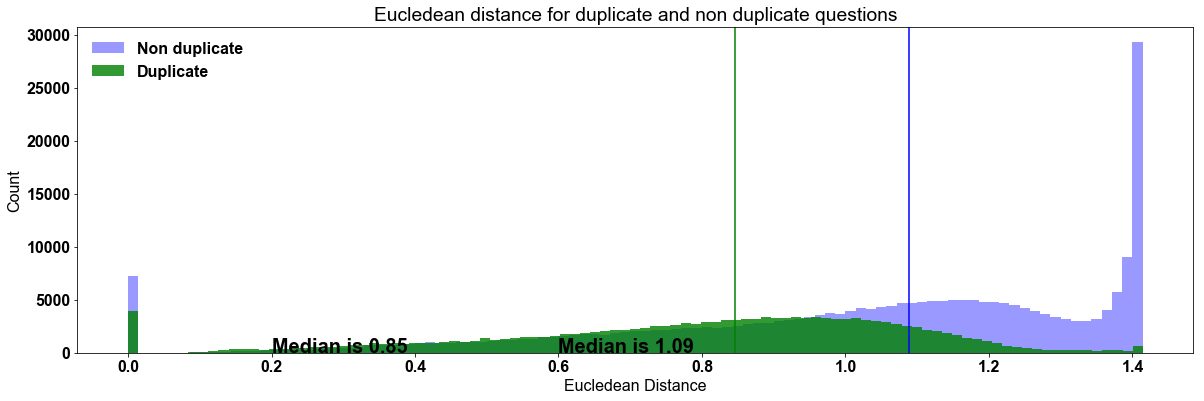

In [41]:
sim_euc_dist = np.zeros(trainq1_trans.shape[0])
sim_euc_dist_non = np.zeros(trainq1_trans_non.shape[0])

for i in range(trainq1_trans.shape[0]):
    sim_euc_dist[i] = spatial.distance.euclidean(trainq1_trans[i],trainq2_trans[i])
    
for i in range(trainq1_trans_non.shape[0]):
    sim_euc_dist_non[i] = spatial.distance.euclidean(trainq1_trans_non[i],trainq2_trans_non[i])
    
plt.figure(figsize=(20,6))

sim_euc_dist = sim_euc_dist[~np.isnan(sim_euc_dist)][sim_euc_dist != float('-inf')]
sim_euc_dist_non = sim_euc_dist_non[~np.isnan(sim_euc_dist_non)][sim_euc_dist_non != float('-inf')]

n, bins, patches = plt.hist(sim_euc_dist_non, bins = 'auto', density=0, facecolor='b', alpha=0.4,label = 'Non duplicate')
n, bins, patches = plt.hist(sim_euc_dist, bins = 'auto', density=0, facecolor='g', alpha=0.8,label = 'Duplicate')
plt.legend(frameon = False)
plt.axvline(np.median(sim_euc_dist_non),color = 'b')
plt.axvline(np.median(sim_euc_dist),color = 'g')
ax = plt.gca()
ax.text(0.2,1, 'Median is {}'.format(np.round(np.median(sim_euc_dist),2)),size=20)
ax.text(0.6,1, 'Median is {}'.format(np.round(np.median(sim_euc_dist_non),2)),size=20)


plt.title('Eucledean distance for duplicate and non duplicate questions')
plt.xlabel('Eucledean Distance')
plt.ylabel('Count')



# Logistic Regression with sag solver

In [6]:
def getBOW(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    # bag of letter sequences (chars)
    """
    BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)
    """
    
    BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)

    BOW.fit(pd.concat((train['question1'],train['question2'])).unique())
    print('Voabulary size is {}'.format(len(BOW.vocabulary_)))
    return BOW
# word level analyzer
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    start_time = time.time()
    print('BOW and logistic regression')
    BOW = getBOW(min_df=min_df,ngrams = ngrams,analyzer = analyzer)
    trainq1_trans = BOW.transform(train['question1'].values)
    trainq2_trans = BOW.transform(train['question2'].values)
    labels = train['is_duplicate'].values
    X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
    y = labels
    X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
    model = linear_model.LogisticRegression(n_jobs=4,solver = 'sag',max_iter = 1000)        
    print('fitting ...')
    model.fit(X_train,y_train)
    print('predicting ...')
    y_pred = model.predict(X_valid)
    loss = log_loss(y_valid,y_pred)
    print('log_loss ... {}'.format(loss))
    accuracy = accuracy_score(y_valid,y_pred)
    print('accuracy is ... {}'.format(accuracy))
    auc = roc_auc_score(y_valid,y_pred)
    print('auc is  ... {}'.format(auc))
    #print("log loss is {}".format(loss))
    end_time =time.time()
    print("total time elapsed is {}".format(end_time-start_time))
    return [loss,accuracy,auc]


In [9]:
train_params(min_df = 100,ngrams = 2,analyzer = 'word',train = train)

BOW and logistic regression
Voabulary size is 8850
fitting ...
predicting ...
log_loss ... 8.505646646538578
accuracy is ... 0.7537383352696473
auc is  ... 0.7153265847533274
total time elapsed is 34.959336042404175


[8.505646646538578, 0.7537383352696473, 0.7153265847533274]

# parameter search for min_df and ngrams

In [24]:
df_arr = [0,10,100,200,400,600]
ngrams = [1,2,3,4]
met = np.zeros(6,4,3)
for i,df in enumerate(df_arr):
    for j,ng in enumerate(ngrams):
        print('df {}: ng {}'.format(df,ng))
        met[i,j,:] = train_params(min_df = df,ngrams = ng,analyzer = 'word',train = train)


df 0: ng 1
BOW and logistic regression
Voabulary size is 86152
fitting ...
predicting ...
log_loss ... 8.295431298682637
accuracy is ... 0.7598246074279503
auc is  ... 0.7214971104342696
total time elapsed is 27.526909828186035
df 0: ng 2
BOW and logistic regression
Voabulary size is 1250860
fitting ...
predicting ...
log_loss ... 7.1897278618903755
accuracy is ... 0.7918374995315369
auc is  ... 0.7526986272803659
total time elapsed is 48.95925498008728
df 0: ng 3
BOW and logistic regression
Voabulary size is 3858251
fitting ...
predicting ...
log_loss ... 6.9474073682759885
accuracy is ... 0.7988532024135218
auc is  ... 0.7574807531520612
total time elapsed is 86.17084693908691
df 0: ng 4
BOW and logistic regression
Voabulary size is 7039102
fitting ...
predicting ...
log_loss ... 6.842038447729713
accuracy is ... 0.8019038339017351
auc is  ... 0.7589035751811409
total time elapsed is 125.26557898521423
df 10: ng 1
BOW and logistic regression
Voabulary size is 18596
fitting ...
predic

ValueError: setting an array element with a sequence.

In [75]:
new_met = np.zeros([6,4,3])
for m in met:
    new_met[m[0],m[1],:] = m[2]  

In [77]:
np.save('logistic.npy',new_met)

# Plot 3 : Model parameter selection

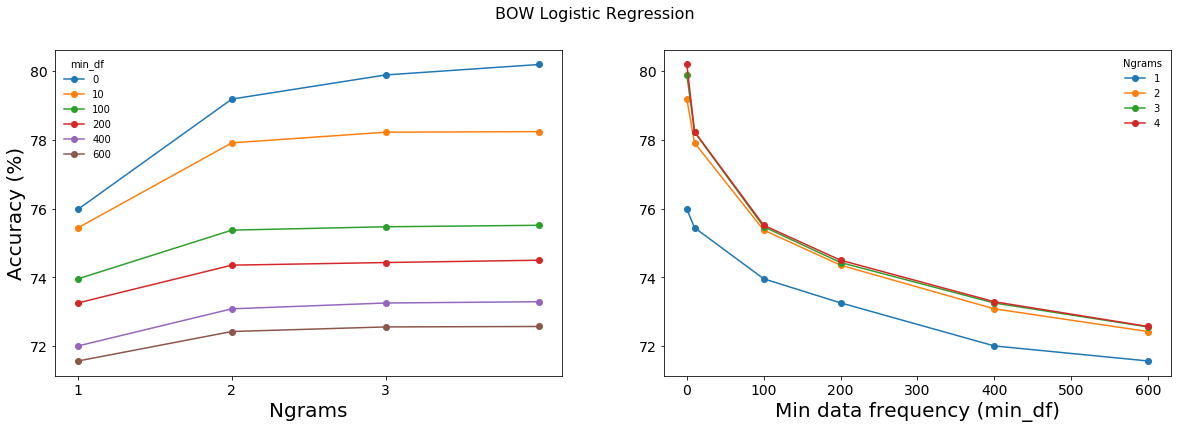

In [7]:
import matplotlib.pyplot as plt
logistic = np.load('logistic.npy')
plt.figure(figsize=(20,6))
plt.suptitle('BOW Logistic Regression', fontsize=16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplot(1,2,1)
ax = plt.gca()
for i in range(6):
    plt.plot(np.arange(1,5),100*logistic[i,:,1],label = df_arr[i],marker = '.',markersize=12)

plt.xticks([1,2,3])
plt.xlabel('Ngrams', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.legend(frameon = False,title = 'min_df')
#ax.text(0.01,1, 'Axes 3',ha='center',va='center',size=24,alpha=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(1,2,2)
for i in range(4):
    plt.plot(df_arr,100*logistic[:,i,1],label = ngrams[i],marker = '.',markersize=12)
ax = plt.gca()
plt.xlabel('Min data frequency (min_df)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(frameon = False,title = 'Ngrams')
plt.savefig('bow_logistic_reg.png',bbox_inches='tight',dpi = 300)

# XGBoost Training for additional 2% accuracy

In [10]:
def train_params_xgb(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    start_time = time.time()
    print('BOW and xgb')
    BOW = getBOW(min_df=min_df,ngrams = ngrams,analyzer = analyzer)
    trainq1_trans = BOW.transform(train['question1'].values)
    trainq2_trans = BOW.transform(train['question2'].values)
    labels = train['is_duplicate'].values
    X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
    y = labels
    X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
    dtrain = xgb.DMatrix(X_train,label = y_train)
    dvalid = xgb.DMatrix(X_valid,label = y_valid)
    print('training ...')
    param = {'max_depth':50, 'eta':0.3, 'silent':0, 'objective':'binary:logistic','subsample':0.9,'gamma':0 }
    param['nthread'] = 7   
    param['eval_metric'] = 'auc'
    #param['tree_method'] = 'hist'
    num_round = 1000
    evallist  = [(dvalid,'eval'),(dtrain,'train')]
    bst = xgb.train(param, dtrain, num_round, evallist)
    y_pred = bst.predict(dvalid)
    loss = log_loss(y_valid,y_pred)
    print('log_loss ... {}'.format(loss))
    accuracy = accuracy_score(y_valid,np.round(y_pred).astype(int))
    print('accuracy is ... {}'.format(accuracy))
    auc = roc_auc_score(y_valid,y_pred)
    print('auc is  ... {}'.format(auc))
    end_time =time.time()
    print("total time elapsed is {}".format(end_time-start_time))
    return [loss,accuracy,auc]

df_arr = [0]
ngrams = [4]
for i,df in enumerate(df_arr):
    for j,ng in enumerate(ngrams):
        print('df {}: ng {}'.format(df,ng))
        met_xgb = train_params_xgb(min_df = df,ngrams = ng,analyzer = 'word',train = train)
np.save('xgb_met.npy',[met_xgb])

df 0: ng 4
BOW and xgb
Voabulary size is 7039133
training ...
[00:02:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 21106 extra nodes, 0 pruned nodes, max_depth=50
[0]	eval-auc:0.759269	train-auc:0.8815
[00:03:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18950 extra nodes, 0 pruned nodes, max_depth=50
[1]	eval-auc:0.788551	train-auc:0.920605
[00:05:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14922 extra nodes, 0 pruned nodes, max_depth=50
[2]	eval-auc:0.803625	train-auc:0.937281
[00:06:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 15752 extra nodes, 0 pruned nodes, max_depth=50
[3]	eval-auc:0.812103	train-auc:0.948337
[00:07:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 13386 extra nodes, 0 pruned nodes, max_depth=50
[

[41]	eval-auc:0.863336	train-auc:0.991608
[00:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=50
[42]	eval-auc:0.863652	train-auc:0.991709
[00:23:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2112 extra nodes, 0 pruned nodes, max_depth=50
[43]	eval-auc:0.864093	train-auc:0.992042
[00:23:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=50
[44]	eval-auc:0.86443	train-auc:0.99217
[00:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 0 pruned nodes, max_depth=50
[45]	eval-auc:0.864836	train-auc:0.992346
[00:24:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=50
[46]	eval-auc:0.865044	tr

[83]	eval-auc:0.87269	train-auc:0.995716
[00:34:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=50
[84]	eval-auc:0.872821	train-auc:0.995811
[00:35:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=50
[85]	eval-auc:0.873091	train-auc:0.995892
[00:35:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=50
[86]	eval-auc:0.873281	train-auc:0.995952
[00:35:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=50
[87]	eval-auc:0.873411	train-auc:0.995987
[00:36:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=50
[88]	eval-auc:0.873493	tr

[125]	eval-auc:0.878503	train-auc:0.99803
[00:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=50
[126]	eval-auc:0.878584	train-auc:0.998056
[00:47:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=50
[127]	eval-auc:0.878628	train-auc:0.998069
[00:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=50
[128]	eval-auc:0.878654	train-auc:0.998079
[00:47:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=50
[129]	eval-auc:0.878703	train-auc:0.998097
[00:48:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=50
[130]	eval-auc:0.8787

[167]	eval-auc:0.881831	train-auc:0.99879
[00:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=50
[168]	eval-auc:0.88186	train-auc:0.998802
[00:58:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1260 extra nodes, 0 pruned nodes, max_depth=50
[169]	eval-auc:0.882012	train-auc:0.998833
[00:59:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=50
[170]	eval-auc:0.882053	train-auc:0.99884
[00:59:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=50
[171]	eval-auc:0.882085	train-auc:0.998846
[00:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=50
[172]	eval-auc:0.88214

[209]	eval-auc:0.884825	train-auc:0.999344
[01:10:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=50
[210]	eval-auc:0.884883	train-auc:0.999359
[01:10:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=50
[211]	eval-auc:0.88491	train-auc:0.999364
[01:10:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=50
[212]	eval-auc:0.884952	train-auc:0.999368
[01:10:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=50
[213]	eval-auc:0.884984	train-auc:0.999374
[01:11:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=50
[214]	eval-auc:0.8850

[251]	eval-auc:0.887126	train-auc:0.999635
[01:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=50
[252]	eval-auc:0.887154	train-auc:0.999638
[01:22:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1128 extra nodes, 0 pruned nodes, max_depth=50
[253]	eval-auc:0.887183	train-auc:0.999646
[01:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=50
[254]	eval-auc:0.887224	train-auc:0.999649
[01:22:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=50
[255]	eval-auc:0.887252	train-auc:0.999651
[01:22:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1602 extra nodes, 0 pruned nodes, max_depth=50
[256]	eval-auc:0.8

[293]	eval-auc:0.888496	train-auc:0.999757
[01:32:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=50
[294]	eval-auc:0.888518	train-auc:0.999759
[01:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=50
[295]	eval-auc:0.888533	train-auc:0.99976
[01:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=50
[296]	eval-auc:0.888553	train-auc:0.999762
[01:33:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=50
[297]	eval-auc:0.888559	train-auc:0.999764
[01:33:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=50
[298]	eval-auc:0.8885

[335]	eval-auc:0.889857	train-auc:0.99983
[01:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=50
[336]	eval-auc:0.88987	train-auc:0.99983
[01:44:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=50
[337]	eval-auc:0.889858	train-auc:0.999831
[01:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1296 extra nodes, 0 pruned nodes, max_depth=50
[338]	eval-auc:0.889956	train-auc:0.999834
[01:44:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=50
[339]	eval-auc:0.889977	train-auc:0.999835
[01:44:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=50
[340]	eval-auc:0.88999

[377]	eval-auc:0.890961	train-auc:0.999899
[01:55:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=50
[378]	eval-auc:0.890976	train-auc:0.9999
[01:55:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=50
[379]	eval-auc:0.89098	train-auc:0.999902
[01:55:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=50
[380]	eval-auc:0.890979	train-auc:0.999902
[01:56:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2214 extra nodes, 0 pruned nodes, max_depth=50
[381]	eval-auc:0.89108	train-auc:0.999907
[01:56:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=50
[382]	eval-auc:0.8911	t

[419]	eval-auc:0.892024	train-auc:0.999936
[02:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=50
[420]	eval-auc:0.892066	train-auc:0.999938
[02:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=50
[421]	eval-auc:0.892122	train-auc:0.99994
[02:07:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=50
[422]	eval-auc:0.89214	train-auc:0.99994
[02:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=50
[423]	eval-auc:0.892177	train-auc:0.999941
[02:07:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=50
[424]	eval-auc:0.892185

[461]	eval-auc:0.893147	train-auc:0.999958
[02:17:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=50
[462]	eval-auc:0.893158	train-auc:0.999958
[02:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=50
[463]	eval-auc:0.893162	train-auc:0.999958
[02:18:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 830 extra nodes, 0 pruned nodes, max_depth=50
[464]	eval-auc:0.893205	train-auc:0.999959
[02:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=50
[465]	eval-auc:0.89323	train-auc:0.999959
[02:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=50
[466]	eval-auc:0.8932

[503]	eval-auc:0.894066	train-auc:0.999971
[02:28:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1046 extra nodes, 0 pruned nodes, max_depth=50
[504]	eval-auc:0.894072	train-auc:0.999972
[02:29:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=50
[505]	eval-auc:0.894074	train-auc:0.999972
[02:29:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=50
[506]	eval-auc:0.8941	train-auc:0.999972
[02:29:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=50
[507]	eval-auc:0.894116	train-auc:0.999971
[02:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=50
[508]	eval-auc:0.8941

[545]	eval-auc:0.894667	train-auc:0.999982
[02:39:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=50
[546]	eval-auc:0.894677	train-auc:0.999982
[02:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=50
[547]	eval-auc:0.894708	train-auc:0.999982
[02:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=50
[548]	eval-auc:0.894726	train-auc:0.999983
[02:40:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2130 extra nodes, 0 pruned nodes, max_depth=50
[549]	eval-auc:0.894753	train-auc:0.999984
[02:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=50
[550]	eval-auc:0.89

[587]	eval-auc:0.895242	train-auc:0.999989
[02:51:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=50
[588]	eval-auc:0.895267	train-auc:0.999988
[02:51:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=50
[589]	eval-auc:0.895266	train-auc:0.999989
[02:51:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=50
[590]	eval-auc:0.895297	train-auc:0.999989
[02:51:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=50
[591]	eval-auc:0.895302	train-auc:0.999989
[02:52:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=50
[592]	eval-auc:0.895

[629]	eval-auc:0.895865	train-auc:0.999991
[03:02:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=50
[630]	eval-auc:0.895863	train-auc:0.999992
[03:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=50
[631]	eval-auc:0.895866	train-auc:0.999992
[03:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=50
[632]	eval-auc:0.895876	train-auc:0.999992
[03:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=50
[633]	eval-auc:0.895883	train-auc:0.999992
[03:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=50
[634]	eval-auc:0.895

[671]	eval-auc:0.896357	train-auc:0.999995
[03:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=50
[672]	eval-auc:0.896371	train-auc:0.999995
[03:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=50
[673]	eval-auc:0.896373	train-auc:0.999995
[03:13:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=50
[674]	eval-auc:0.896397	train-auc:0.999995
[03:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=50
[675]	eval-auc:0.896397	train-auc:0.999995
[03:14:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=50
[676]	eval-auc:0.896

[713]	eval-auc:0.89676	train-auc:0.999995
[03:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 680 extra nodes, 0 pruned nodes, max_depth=50
[714]	eval-auc:0.896762	train-auc:0.999995
[03:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=50
[715]	eval-auc:0.896761	train-auc:0.999995
[03:24:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=50
[716]	eval-auc:0.896768	train-auc:0.999995
[03:25:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=50
[717]	eval-auc:0.896783	train-auc:0.999995
[03:25:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1080 extra nodes, 0 pruned nodes, max_depth=50
[718]	eval-auc:0.896

[755]	eval-auc:0.897178	train-auc:0.999996
[03:35:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=50
[756]	eval-auc:0.897226	train-auc:0.999996
[03:35:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=50
[757]	eval-auc:0.897245	train-auc:0.999996
[03:35:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=50
[758]	eval-auc:0.897268	train-auc:0.999997
[03:36:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=50
[759]	eval-auc:0.897276	train-auc:0.999996
[03:36:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=50
[760]	eval-auc:0.89

[797]	eval-auc:0.897617	train-auc:0.999997
[03:46:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=50
[798]	eval-auc:0.897625	train-auc:0.999997
[03:46:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=50
[799]	eval-auc:0.897631	train-auc:0.999997
[03:46:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=50
[800]	eval-auc:0.897643	train-auc:0.999997
[03:47:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=50
[801]	eval-auc:0.897649	train-auc:0.999997
[03:47:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=50
[802]	eval-auc:0.897

[839]	eval-auc:0.898129	train-auc:0.999998
[03:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=50
[840]	eval-auc:0.898127	train-auc:0.999997
[03:57:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=50
[841]	eval-auc:0.898125	train-auc:0.999997
[03:57:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=50
[842]	eval-auc:0.898139	train-auc:0.999997
[03:58:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=50
[843]	eval-auc:0.898131	train-auc:0.999997
[03:58:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=50
[844]	eval-auc:0.898

[881]	eval-auc:0.898302	train-auc:0.999998
[04:08:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=50
[882]	eval-auc:0.898314	train-auc:0.999998
[04:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=50
[883]	eval-auc:0.898316	train-auc:0.999998
[04:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=50
[884]	eval-auc:0.898313	train-auc:0.999998
[04:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=50
[885]	eval-auc:0.898315	train-auc:0.999998
[04:09:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=50
[886]	eval-auc:0.898

[923]	eval-auc:0.898601	train-auc:0.999998
[04:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=50
[924]	eval-auc:0.898598	train-auc:0.999998
[04:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=50
[925]	eval-auc:0.898616	train-auc:0.999998
[04:19:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=50
[926]	eval-auc:0.898625	train-auc:0.999998
[04:20:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=50
[927]	eval-auc:0.898639	train-auc:0.999998
[04:20:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=50
[928]	eval-auc:0.89

[965]	eval-auc:0.898824	train-auc:0.999998
[04:30:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1334 extra nodes, 0 pruned nodes, max_depth=50
[966]	eval-auc:0.898843	train-auc:0.999998
[04:30:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=50
[967]	eval-auc:0.898844	train-auc:0.999999
[04:30:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=50
[968]	eval-auc:0.898856	train-auc:0.999999
[04:31:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=50
[969]	eval-auc:0.898886	train-auc:0.999999
[04:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=50
[970]	eval-auc:0.89

In [ ]:
xgb_met = np.load('xgb_met.npy')